# Create CIGALE data file for (VIKING+DES+CATWISE) sources

Select a subsample of VIKING+DES+CATWISE sources that have the same distribution as EMU sources in a given magnitude.

# Import Libraries

In [1]:
import numpy as np
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import missingno

# Define the directory

In [2]:
observatory = '/home/mfonseca/fastdisk'
my_computer = '/home/polaris/Lab_Astro/data/'

directory = my_computer

# Import data

## Import EMU+VIKING+DES+CATWISE crossmatch data

In [3]:
emu_matched_no_mags_path = directory + 'cross_match/EMU_0102-32_DESY6GOLD_VIKING_CATWISE_noMags/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_petro_2.fits'
emu_matched_no_mags = Table.read(emu_matched_no_mags_path).filled()
emu_matched_no_mags = emu_matched_no_mags.to_pandas()

match_mask = (emu_matched_no_mags['match_flag'] == 1) & (emu_matched_no_mags['p_i'] >= 0.1) & (emu_matched_no_mags['p_any'] >=0.83)
catalog_matches_noMags = emu_matched_no_mags[match_mask]
print(f'Number of objects in the catalog {len(catalog_matches_noMags)}')

# Here we select objects that have matches in all three surveys
full_match_mask = (catalog_matches_noMags['DESY6_coadd_object_id'] != -99) & (catalog_matches_noMags['VKG_sourceID'] != -99) & (catalog_matches_noMags['CAT_source_id'] != b'-99')
emu_catalog_matches_noMags_full = catalog_matches_noMags[full_match_mask]

# Ignore the warning
emu_catalog_matches_noMags_full['EMU_island_name'] = emu_catalog_matches_noMags_full['EMU_island_name'].str.decode('utf-8').str.strip(' ')

print(f'Number of objects in the catalog that have matches in all three surveys {len(emu_catalog_matches_noMags_full)}')

emu_catalog_matches_noMags_full.drop(columns=['DESY6_mag_auto_y_extcorr', 'DESY6_z_y_extcorr','VKG_magerr_petro_z', 'VKG_mag_petro_z_ab_extcorr'], inplace=True)
emu_catalog_matches_noMags_full.dropna(inplace=True)

print(f'Number of objects in the catalog that have matches in all three surveys and have full photometry {len(emu_catalog_matches_noMags_full)}')

Number of objects in the catalog 11695
Number of objects in the catalog that have matches in all three surveys 3855
Number of objects in the catalog that have matches in all three surveys and have full photometry 3530


/tmp/ipykernel_117689/2011678717.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_catalog_matches_noMags_full['EMU_island_name'] = emu_catalog_matches_noMags_full['EMU_island_name'].str.decode('utf-8').str.strip(' ')
/tmp/ipykernel_117689/2011678717.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_catalog_matches_noMags_full.drop(columns=['DESY6_mag_auto_y_extcorr', 'DESY6_z_y_extcorr','VKG_magerr_petro_z', 'VKG_mag_petro_z_ab_extcorr'], inplace=True)
/tmp/ipykernel_117689/2011678717.py:19: SettingWithCopyWarning: 
A value is trying to be set on a

## Import VIKING+DES+CATWISE crossmatch data

In [4]:
other_matched_no_mags_path = directory + 'cross_match/without_EMU/DESY6_VKG_CAT_noMags/DESY6_VKG_CAT_noMags.fits'
other_matched_no_mags = Table.read(other_matched_no_mags_path).filled()
other_matched_no_mags = other_matched_no_mags.to_pandas()

# Match criteria from NWAY
match_mask = (other_matched_no_mags['match_flag'] == 1) & (other_matched_no_mags['p_i'] > 0.1) & (other_matched_no_mags['p_any'] >0.00)
other_catalog_matches_noMags = other_matched_no_mags[match_mask]
print(f'Number of objects in the catalog {len(other_catalog_matches_noMags)}')

# Here we select objects that have matches in DES and CATWISE surveys
full_match_mask = (other_catalog_matches_noMags['DESY6_coadd_object_id'] != -99) & (other_catalog_matches_noMags['CAT_source_id'] != b'-99')
other_catalog_matches_noMags_full = other_catalog_matches_noMags[full_match_mask]

print(f'Number of objects in the catalog that have matches in all three surveys {len(other_catalog_matches_noMags_full)}')

Number of objects in the catalog 587677
Number of objects in the catalog that have matches in all three surveys 366961


## Remove EMU+VIKING+DES+CATWISE crossmatch data from VIKING+DES+CATWISE

In [5]:
# Columns to compare (same names in both DataFrames)
compare_cols = ['DESY6_coadd_object_id', 'VKG_sourceID', 'CAT_source_name']

# Step 1: Create a merge key to identify matching rows
other_catalog_matches_noMags_full['_merge_key'] = other_catalog_matches_noMags_full[compare_cols].astype(str).agg('_'.join, axis=1)
emu_catalog_matches_noMags_full['_merge_key'] = emu_catalog_matches_noMags_full[compare_cols].astype(str).agg('_'.join, axis=1)

# Step 2: Remove rows from df1 where values in compare_cols match any row in df2
non_emu_fullphot_filtered = other_catalog_matches_noMags_full[~other_catalog_matches_noMags_full['_merge_key'].isin(emu_catalog_matches_noMags_full['_merge_key'])].copy()

# Step 3: Drop the helper column
non_emu_fullphot_filtered.drop(columns=['_merge_key'], inplace=True)
emu_catalog_matches_noMags_full.drop(columns=['_merge_key'], inplace=True)

# Step 4: Add source_flag (0 = from other_catalog_matches_noMags_full, 1 = from emu_catalog_matches_noMags_full)
# other_catalog_matches_noMags_full['source_flag'] = 0
# emu_catalog_matches_noMags_full['source_flag'] = 1

# Step 5: Append df2 to the filtered df1
# final_df = pd.concat([other_catalog_matches_noMags_full, emu_catalog_matches_noMags_full], ignore_index=True)
final_df = non_emu_fullphot_filtered

print(f'Number of objects in the catalog that have matches in all three surveys and have full photometry but are not in EMU {len(final_df)}')

/tmp/ipykernel_117689/2347824584.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_catalog_matches_noMags_full['_merge_key'] = other_catalog_matches_noMags_full[compare_cols].astype(str).agg('_'.join, axis=1)
/tmp/ipykernel_117689/2347824584.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_catalog_matches_noMags_full['_merge_key'] = emu_catalog_matches_noMags_full[compare_cols].astype(str).agg('_'.join, axis=1)


Number of objects in the catalog that have matches in all three surveys and have full photometry but are not in EMU 363431


/tmp/ipykernel_117689/2347824584.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_catalog_matches_noMags_full.drop(columns=['_merge_key'], inplace=True)


# Select a subsample of VIKING+DES+CATWISE with similar distribution to EMU+VIKING+DES+CATWISE

In [6]:
def match_distribution_by_binning(df1, df2, column, bins, n_subsamples, random_state=None):
    """
    Returns a single DataFrame containing multiple non-overlapping subsamples of df1,
    each matching the distribution of df2[column], without adding new columns.

    Parameters:
    - df1: pandas DataFrame to sample from
    - df2: pandas DataFrame with reference distribution
    - column: str, column to match distribution on
    - bins: int or sequence, used for binning the column
    - n_subsamples: int, number of non-overlapping subsamples to extract
    - random_state: int or None, for reproducibility

    Returns:
    - pandas DataFrame containing the combined subsamples
    """
    rng = np.random.default_rng(random_state)
    
    # Create binned copies
    df1_binned = df1.copy()
    df2_binned = df2.copy()
    df1_binned['bin'] = pd.cut(df1_binned[column], bins=bins, include_lowest=True)
    df2_binned['bin'] = pd.cut(df2_binned[column], bins=bins, include_lowest=True)
    
    # Target distribution per bin
    target_counts = df2_binned['bin'].value_counts().sort_index()
    
    # Split df1 into bin groups
    bin_groups = {b: df1_binned[df1_binned['bin'] == b].copy() for b in target_counts.index}
    
    all_sampled = []

    for _ in range(n_subsamples):
        current_sample_indices = []
        for b, target_count in target_counts.items():
            group = bin_groups.get(b, pd.DataFrame())
            if len(group) < target_count:
                break  # Not enough data in this bin to continue
            selected = rng.choice(group.index, size=target_count, replace=False)
            current_sample_indices.extend(selected)
            bin_groups[b].drop(index=selected, inplace=True)
        else:
            # All bins sampled successfully
            sample = df1.loc[current_sample_indices].copy()
            all_sampled.append(sample)
            continue
        break  # Exit if any bin couldn't be fulfilled

    # Combine all samples into a single DataFrame
    return pd.concat(all_sampled, ignore_index=True)

In [9]:
bins = np.linspace(emu_catalog_matches_noMags_full['DESY6_mag_auto_i_extcorr'].min(), emu_catalog_matches_noMags_full['DESY6_mag_auto_i_extcorr'].max(), 50, 42)
#subsample_df1 = match_distribution_by_binning(final_df, emu_catalog_matches_noMags_full, 'DESY6_mag_auto_i_extcorr', bins, 4,random_state=42)

#print(len(subsample_df1))

# Save the subsample to a new file
#subsample_df1.to_csv('/home/polaris/Lab_Astro/data/cigale/nonemu_data/nonemu_data_sample4.data', index=False)
final_df.to_csv('/home/polaris/Lab_Astro/data/cigale/nonemu_data/nonemu_data.data', index=False)

# SANITY CHECK: Plot the distributions 

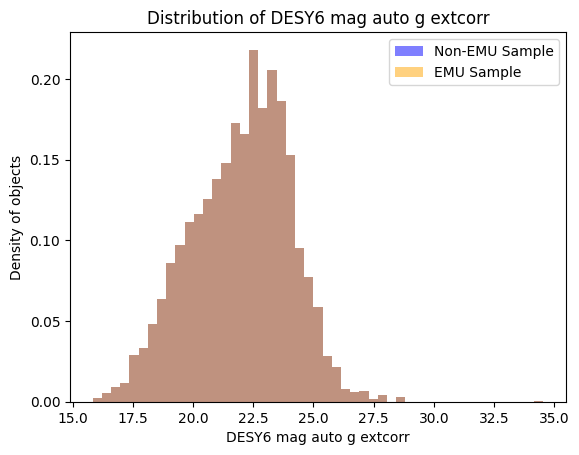

In [ ]:
plt.hist(subsample_df1['DESY6_mag_auto_g_extcorr'], bins=bins, alpha=0.5, label='Non-EMU Sample', color='blue', density=True)
plt.hist(emu_catalog_matches_noMags_full['DESY6_mag_auto_g_extcorr'], bins=bins, alpha=0.5, label='EMU Sample', color='orange', density=True)
plt.xlabel('DESY6 mag auto g extcorr')
plt.ylabel('Density of objects')
plt.legend()
plt.title('Distribution of DESY6 mag auto g extcorr')
plt.show()